In [45]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing



In [134]:
tsla_df = yf.download('TSLA', 
                      start='2019-01-01', 
                      end='2019-12-31', 
                      progress=False)
tsla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,22.519333,22.614000,21.684000,22.186666,22.186666,94534500
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000


In [2]:
dow_30_tickers = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO',
                 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ',
                 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 
                 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V',
                 'WBA', 'WMT', 'DIS', 'DOW']

In [3]:
def add_ticker_name(df, ticker):
    df.set_axis([ticker + '_' + col for col in list(df.columns)], axis=1, inplace=True)
    return df

On va commencer par prendre un df avec 2 stock, on va calculer les indic (mva, rsi etc) et tout les jours en acheter un et short l'autre

In [4]:
df = yf.download('AXP', start = '2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [5]:
### Functions to get classical Technical Trading indicators

# Simple Moving Average 
def SMA(data, ndays): 
    data['SMA_'+str(ndays)] = pd.Series(data['Close'].rolling(ndays).mean())
    return data

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
    data['EWMA_' + str(ndays)] = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean())
    return data

def rsi(df, periods = 14):
    
    close = df.Close
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    
    df['rsi_' + str(periods)] = rsi
    return df

def gain(x):
    return ((x > 0) * x).sum()
def loss(x):
    return ((x < 0) * x).sum()


# Calculate money flow index
def mfi(df, n=14):
    typical_price = (df.High + df.Low + df.Close)/3
    money_flow = typical_price * df.Volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    mfi = (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()
    
    df['mfi_' + str(n)] = mfi
    
    return df
    
    # Returns ATR values
def atr(df, n=14):
    tr = np.amax(np.vstack(((df.High - df.Low).to_numpy(), (abs(df.High - df.Close)).to_numpy(), (abs(df.Low - df.Close)).to_numpy())).T, axis=1)    
    atr = pd.Series(tr).rolling(n).mean().to_numpy()
    df['atr_' + str(n)] = atr
    return df

def ForceIndex(data, ndays = 1): 
    data['ForceIndex_' + str(ndays)] = pd.Series(data['Close'].diff(ndays) * data['Volume']) 
    return data

def EMV(data, ndays = 14): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name = 'EMV') 
    data['EMV_MA_' + str(ndays)] = EMV_MA
    return data 


def get_all_technical_indicators(data):

    data = SMA(data, 5)
    data = SMA(data, 50)
    data = SMA(data, 200)
    
    data = EWMA(data, 5)
    data = EWMA(data, 50)
    data = EWMA(data, 200)
    
    data = rsi(data)
    data = mfi(data)
    data = atr(data)
    data = ForceIndex(data)
    data = EMV(data)
    
    return data

In [6]:
df = get_all_technical_indicators(df)

In [7]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_50,SMA_200,EWMA_5,EWMA_50,EWMA_200,rsi_14,mfi_14,atr_14,ForceIndex_1,EMV_MA_14
Date,,,,,,,,,,,,,,,,,
2022-10-24,141.300003,143.789993,140.369995,141.630005,141.630005,4299600,142.810001,149.185600,163.47655,141.635400,146.392035,156.709780,47.577284,37.842221,4.762859,6.836414e+06,-16.682195
2022-10-25,142.479996,147.440002,141.600006,147.020004,147.020004,3889100,143.016000,148.818000,163.33975,143.430268,146.416661,156.613364,54.531512,43.713049,4.950716,2.096225e+07,16.178296
2022-10-26,147.559998,149.500000,146.470001,146.880005,146.880005,3559100,143.598001,148.448600,163.20545,144.580180,146.434831,156.516515,54.329912,49.334985,4.957860,-4.982718e+05,37.994543
2022-10-27,148.440002,149.710007,146.410004,146.970001,146.970001,2101300,144.508002,148.110001,163.06340,145.376787,146.455818,156.421524,54.446499,53.506562,4.964289,1.891093e+05,73.594968
2022-10-28,148.440002,146.899994,146.050003,146.460007,146.460007,89289,145.792004,147.746201,162.92335,145.737860,146.455982,156.322405,53.611285,56.216292,4.758573,-4.553690e+04,-23.406813


In [8]:
# Function to prepare data for models

# add label to data (one day return):

def add_next_day_return(df):
    
    close_start = np.array(df.Close[0:-1])
    close_end = np.array(df.Close[1:])
    one_day_return = (close_end - close_start) / close_start    
    
    df = df[0:-1]
    #df['One_day_return'] = one_day_return
    df.loc[:,'Next_day_return'] = one_day_return
    
    return df


def sep_train_test(df, date_start_train = '2015-01-01', date_end_train = '2021-01-01'):
    
    df = df.dropna()
    
    train = df[df.index < date_end_train]
    train = train[train.index >= date_start_train]
    
    test = df[df.index >= date_end_train]
    
    y_train = train.pop('Next_day_return')
    
    y_test = test.pop('Next_day_return')

    
    return train, y_train, test, y_test


def sep_train_test(df, date_start_train = '2015-01-01', date_end_train = '2021-01-01'):
    
    df = df.dropna()
    
    train = df[df.index < date_end_train]
    train = train[train.index >= date_start_train]
    
    test = df[df.index >= date_end_train]
    
    y_train = train.pop('Next_day_return')
    
    y_test = test.pop('Next_day_return')

    
    return train, y_train, test, y_test



def sep_train_test_scaled(df, date_start_train = '2015-01-01', date_end_train = '2021-01-01'):
    
    df = df.dropna()
    
    
    x = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled)

    
    train = df_scaled[df_scaled.index < len(df[df.index < '2021-01-01'])]
    #train = train[train.index >= date_start_train]
    
    test = df_scaled[df_scaled.index >= len(df[df.index < '2021-01-01'])]
    
    y_train = train.pop(list(df_scaled.columns)[-1])
    
    y_test = test.pop(list(df_scaled.columns)[-1])

    
    return train, y_train, test, y_test



In [9]:
df = add_next_day_return(df)

date_start_train = '2015-01-01'
date_end_train = '2021-01-01'

X_train, y_train, X_test, y_test = sep_train_test(df, date_start_train, date_end_train)

X_scaled_train, y_scaled_train, X_scaled_test, y_scaled_test = sep_train_test_scaled(df, date_start_train, date_end_train)

/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


In [10]:
X_scaled_train.index = list(X_train.index)
y_scaled_train.index = list(y_train.index)
X_scaled_test.index = list(X_test.index)
y_scaled_test.index = list(y_test.index)

## First test : try to do a regression on one day return for one stock

### RF Regressor

In [11]:
RF_reg = RandomForestRegressor(max_depth=10, random_state=0)
RF_reg.fit(X_scaled_train, y_scaled_train)

y_scaled_pred = RF_reg.predict(X_scaled_test)
y_scaled_train_pred = RF_reg.predict(X_scaled_train)

In [ ]:
for i in range(10):
    print(test_res['y_train_pred'].quantile(i/10))

In [13]:
np.quantile(y_pred, 0.75)

NameError: name 'y_pred' is not defined

In [183]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test, y_pred)

26.450761122537443

## Implement our strategy

We will buy the stock at Close Price if we have a buy signal and sell it at Close Price as soon as the buy signal is over

In [15]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,y_pred
2021-01-04,0.479081,0.474520,0.453018,0.454471,0.459674,0.064191,0.464694,0.438051,0.339289,0.463836,0.448918,0.395394,0.560515,0.285122,0.215096,0.467320,0.607221,0.404008
2021-01-05,0.458299,0.457488,0.454719,0.458749,0.463767,0.032633,0.465126,0.440214,0.341279,0.463576,0.450259,0.396471,0.582551,0.317504,0.191454,0.483718,0.599391,0.404523
2021-01-06,0.477030,0.494323,0.479962,0.488558,0.492292,0.119659,0.471975,0.443655,0.343695,0.473618,0.452941,0.397943,0.712902,0.465700,0.192811,0.519141,0.647593,0.398459
2021-01-07,0.498223,0.500811,0.456420,0.479052,0.485967,0.185475,0.475080,0.447517,0.345375,0.477054,0.455072,0.399272,0.658003,0.323016,0.248962,0.464111,0.627783,0.394739
2021-01-08,0.484345,0.477224,0.471185,0.479867,0.486750,0.051710,0.476291,0.451702,0.346787,0.479625,0.457159,0.400598,0.661447,0.238792,0.260703,0.482297,0.620939,0.401570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-21,0.613686,0.606448,0.557529,0.603857,0.625171,0.256249,0.630475,0.723967,0.908689,0.623385,0.708974,0.858318,0.471645,0.283640,0.452476,0.441205,0.619207,0.302996
2022-10-24,0.615805,0.623141,0.613050,0.614653,0.635758,0.083401,0.630600,0.720194,0.907292,0.623366,0.707402,0.856910,0.505521,0.310824,0.459665,0.491710,0.592511,0.304743
2022-10-25,0.623872,0.647810,0.621419,0.651253,0.671649,0.073871,0.632034,0.717330,0.906070,0.635895,0.707601,0.856015,0.608291,0.383224,0.480671,0.512216,0.641345,0.308835
2022-10-26,0.658600,0.661733,0.654555,0.650302,0.670716,0.066210,0.636085,0.714451,0.904870,0.643922,0.707748,0.855116,0.605311,0.452554,0.481470,0.481062,0.673766,0.309150


In [16]:
test = X_scaled_test
test['y_pred'] = y_scaled_pred

def buy_signal(row):
    if(row['y_pred'] < np.quantile(y_scaled_pred, 0.75)):
        val = 0
    else:
        val = 1
    return val

test['buy_signal'] = test.apply(buy_signal, axis=1)

X_test['buy_signal'] = test['buy_signal']

In [18]:
X_test

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_50,SMA_200,EWMA_5,EWMA_50,EWMA_200,rsi_14,mfi_14,atr_14,ForceIndex_1,EMV_MA_14,buy_signal
Date,,,,,,,,,,,,,,,,,,
2021-01-04,121.300003,121.800003,116.849998,118.040001,115.185806,3472100,118.976001,112.979800,99.88940,118.781698,114.443484,107.009248,51.298608,35.758067,2.575714,-9.964937e+06,-6.783815,1
2021-01-05,118.260002,119.279999,117.099998,118.669998,115.800575,2112700,119.038000,113.257400,100.11215,118.744464,114.609229,107.125276,52.789745,38.383854,2.364286,1.330995e+06,-12.053203,1
2021-01-06,121.000000,124.730003,120.809998,123.059998,120.084427,5861500,120.022000,113.699000,100.38265,120.182975,114.940632,107.283830,61.610392,50.400996,2.376429,2.573198e+07,20.382418,1
2021-01-07,124.099998,125.690002,117.349998,121.660004,119.134575,8696600,120.468001,114.194600,100.57070,120.675318,115.204137,107.426877,57.895427,38.830844,2.878572,-1.217519e+07,7.051911,1
2021-01-08,122.070000,122.199997,119.519997,121.779999,119.252075,2934500,120.642000,114.731600,100.72875,121.043545,115.462014,107.569694,58.128473,32.001130,2.983572,3.521257e+05,2.446571,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-21,140.990005,141.320007,132.210007,140.039993,140.039993,11745300,142.791998,149.669800,163.63290,141.638097,146.586403,156.861335,45.284982,35.637821,4.698574,-2.795387e+07,1.281224,0
2022-10-24,141.300003,143.789993,140.369995,141.630005,141.630005,4299600,142.810001,149.185600,163.47655,141.635400,146.392035,156.709780,47.577284,37.842221,4.762859,6.836414e+06,-16.682195,0
2022-10-25,142.479996,147.440002,141.600006,147.020004,147.020004,3889100,143.016000,148.818000,163.33975,143.430268,146.416661,156.613364,54.531512,43.713049,4.950716,2.096225e+07,16.178296,0


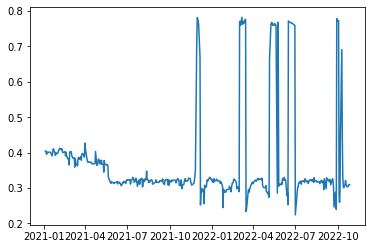

In [20]:
plt.plot(test['y_pred'])

In [21]:
# We only buy one stock and sell one stock

trades = []

shares_bought = [0 for i in range(len(X_test))]
shares_sold = [0 for i in range(len(X_test))]


i = 0
is_bought = 0
while(i < (len(X_test))):
    if(is_bought):
        if(X_test.iloc[i]['buy_signal'] == 0):
            price_sell = X_test.iloc[i]['Close']
            trades.append(price_sell - price_bought)
            is_bought = 0
    else:
        if((X_test.iloc[i]['buy_signal'] == 1)):
            price_bought = X_test.iloc[i]['Close']
            is_bought = 1
    i += 1
    

In [22]:
# We invest money_invested on our strategy

trades = []
money_invested = 10000

money_available = money_invested
current_portfolio_value = []

num_shares_bought = [0 for i in range(len(X_test))]
num_shares_sold = [0 for i in range(len(X_test))]


i = 0
is_bought = 0
current_num_shares = 0

while(i < (len(X_test))):
    if(is_bought):
        if(X_test.iloc[i]['buy_signal'] == 0):
            price_sell = X_test.iloc[i]['Close']
            #trades.append(price_sell - price_bought)
            is_bought = 0
            
            num_shares_sold[i] = current_num_shares
            money_available += current_num_shares * price_sell
            
            current_num_shares = 0
            
    else:
        if((X_test.iloc[i]['buy_signal'] == 1)):
            price_bought = X_test.iloc[i]['Close']
            is_bought = 1
            
            num_shares_bought[i] = money_available // X_test.iloc[i].Close
            current_num_shares = num_shares_bought[i]
            money_available -=  current_num_shares * price_bought
            #current_portfolio = current_portfolio - num_shares * X_test.iloc[0].Close
            
    current_portfolio_value.append(money_available + current_num_shares * X_test.iloc[i].Close)
    
    i += 1
    
    
# Baseline : buy and hold strategy

money_invested = 10000
money_available_baseline = money_invested

current_portfolio_baseline_value = []

num_shares_baseline =  money_invested // X_test.iloc[0]['Close']
money_available_baseline = money_invested % X_test.iloc[0]['Close']

for i in range(len(X_test)):
    current_portfolio_baseline_value.append(money_available_baseline + num_shares_baseline * X_test.iloc[i].Close)

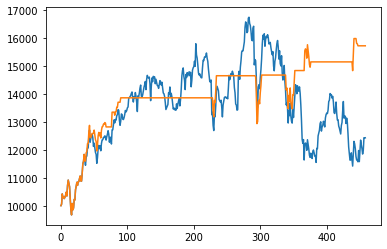

In [29]:
plt.plot(current_portfolio_baseline_value)
plt.plot(current_portfolio_value)

In [26]:
num_shares_hold = []
current_shares_hold = 0
for i in range(len(num_shares_bought)):
    current_shares_hold = current_shares_hold + num_shares_bought[i] - num_shares_sold[i]
    num_shares_hold.append(current_shares_hold)


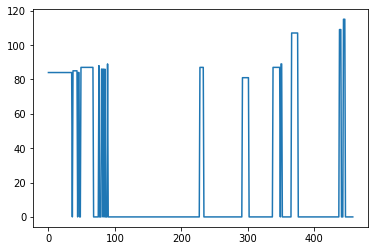

In [27]:
plt.plot(num_shares_hold)

In [238]:
trades

[19.040000915527344,
 9.840011596679688,
 1.7899932861328125,
 3.8300018310546875,
 -1.04998779296875,
 6.0099945068359375,
 0.1699981689453125,
 1.8600006103515625,
 2.0999908447265625,
 1.779998779296875,
 9.089996337890625,
 0.3000030517578125,
 -8.110000610351562,
 9.739990234375,
 2.899993896484375,
 7.670013427734375,
 -2.2599945068359375]

## Same strategy on every stock

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


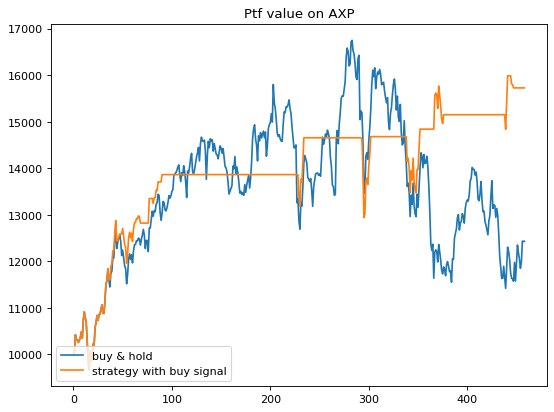

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


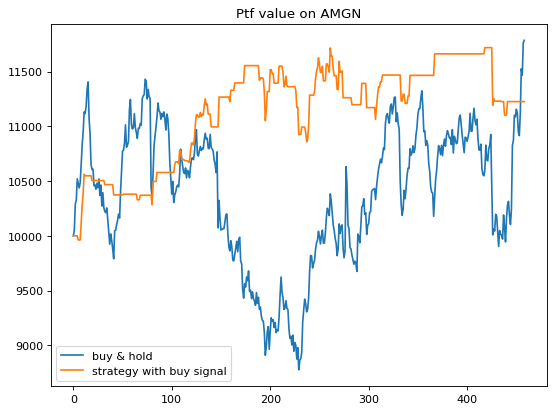

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


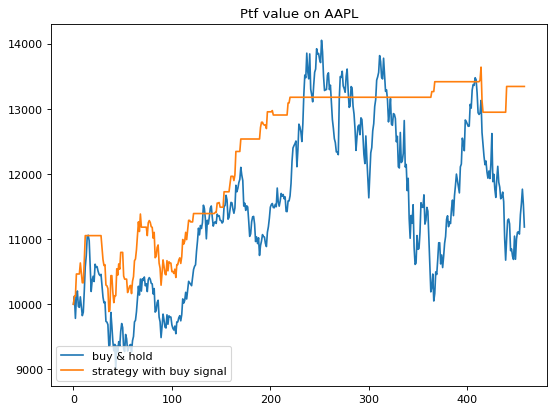

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


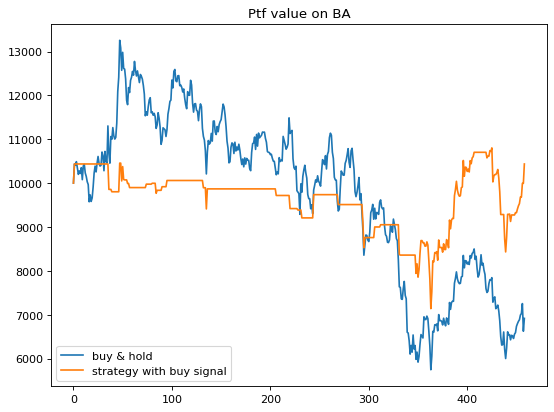

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


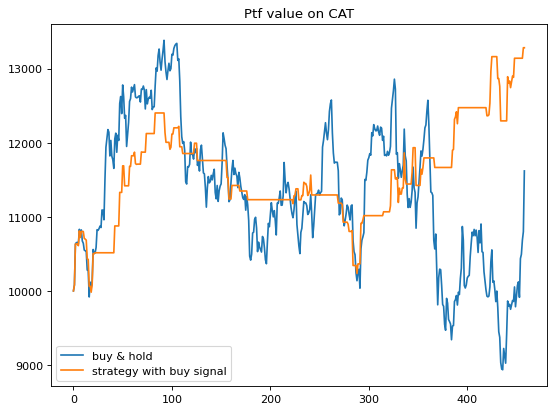

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


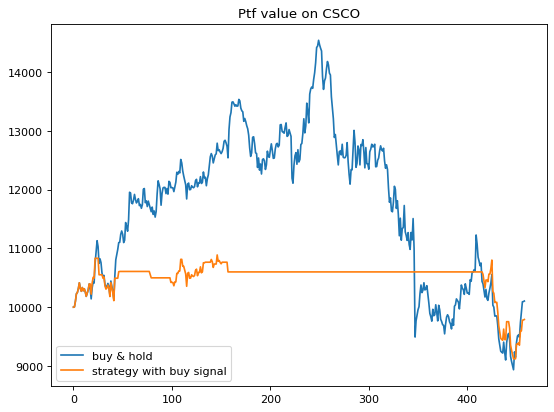

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


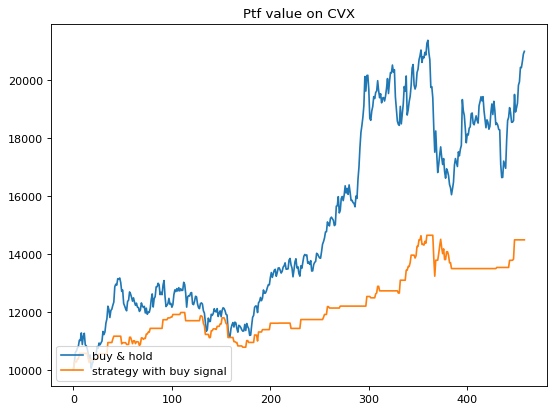

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


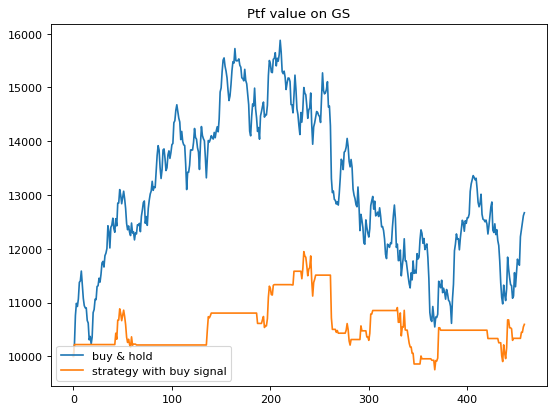

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


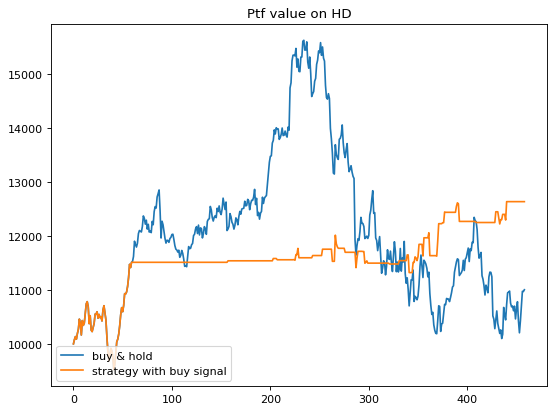

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


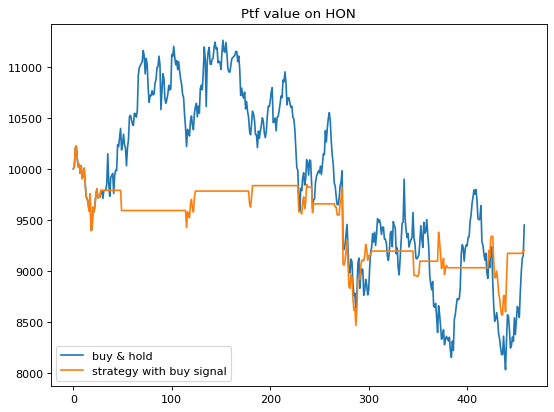

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


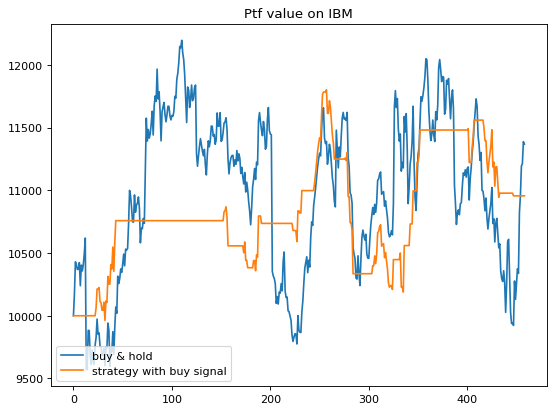

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


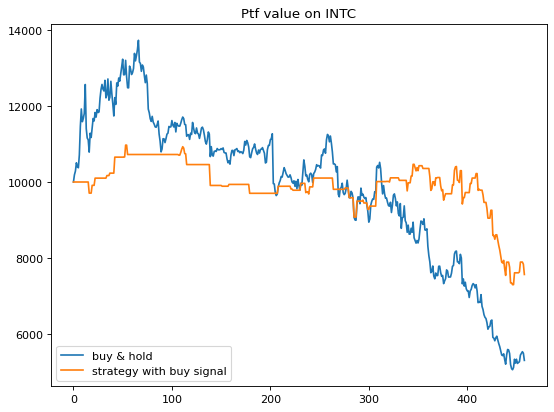

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


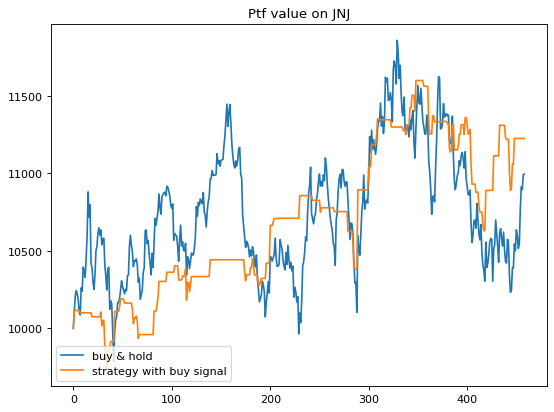

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


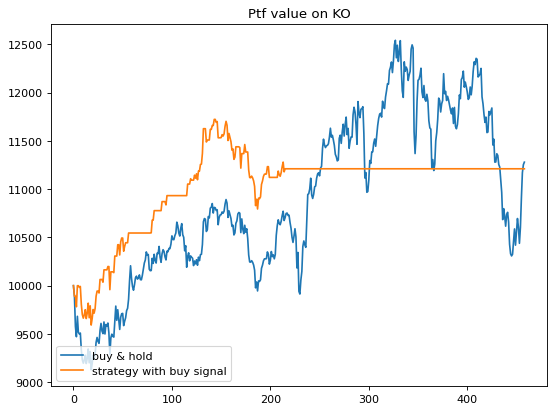

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


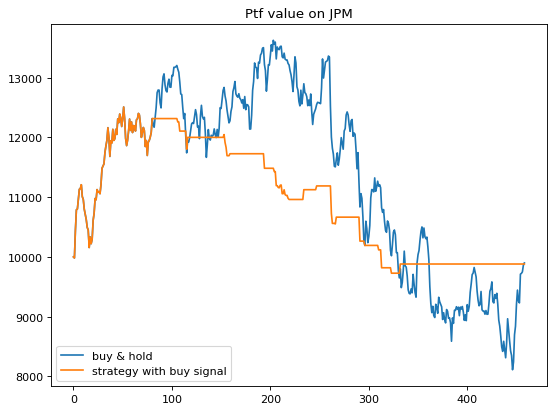

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


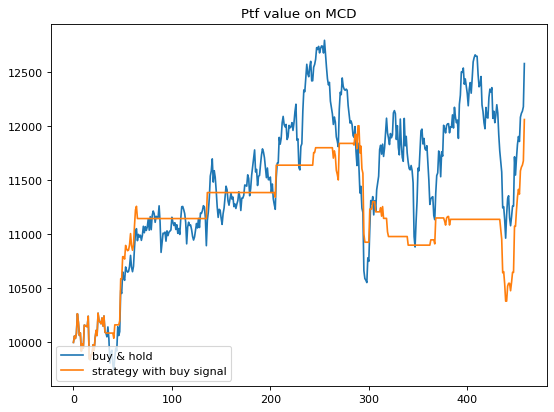

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


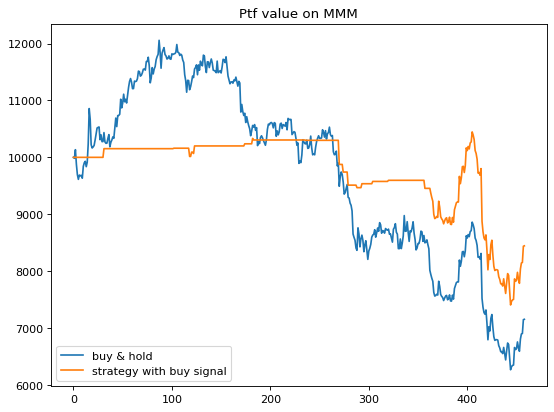

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


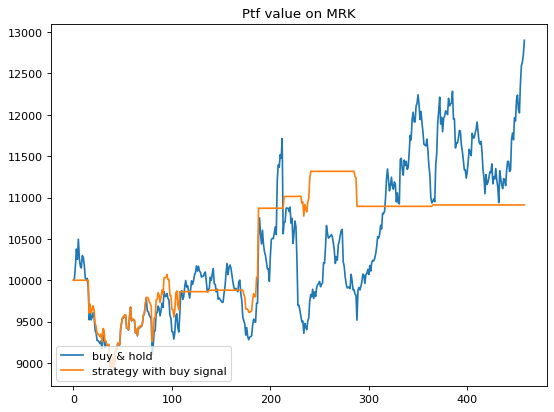

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


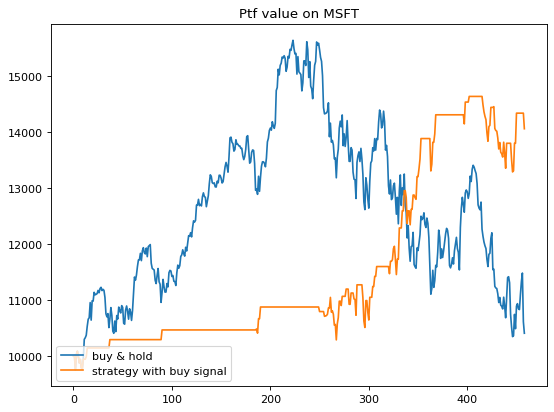

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


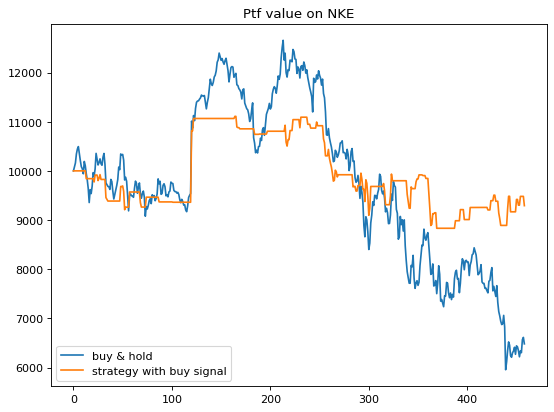

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


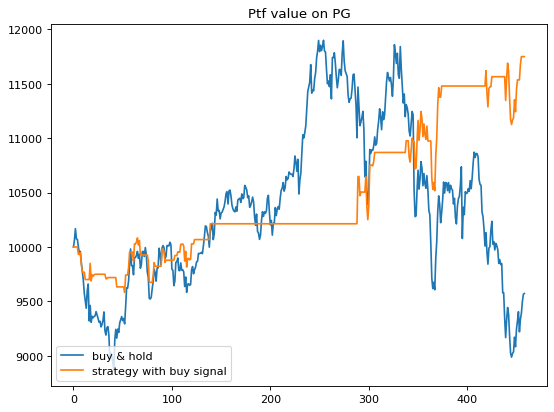

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


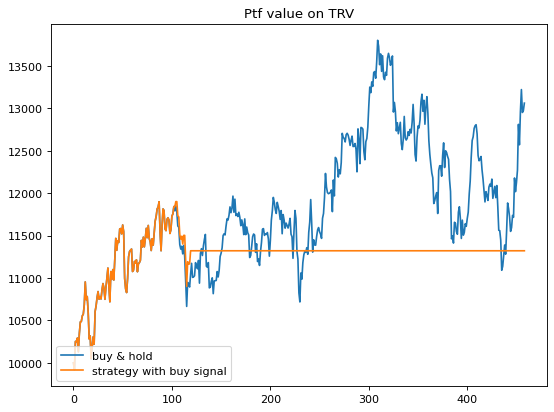

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


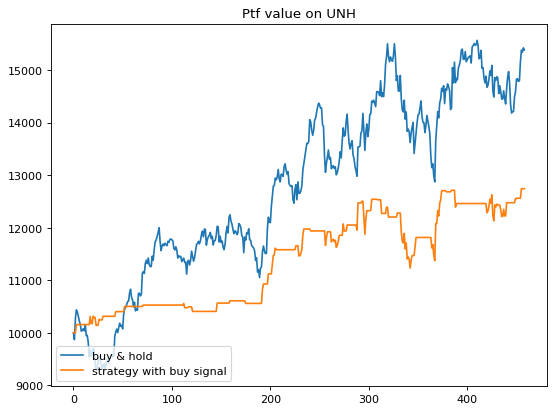

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


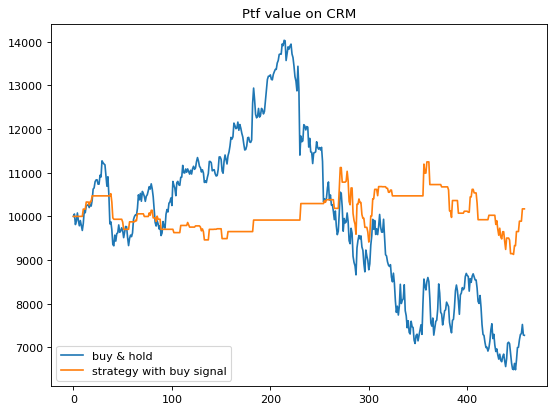

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


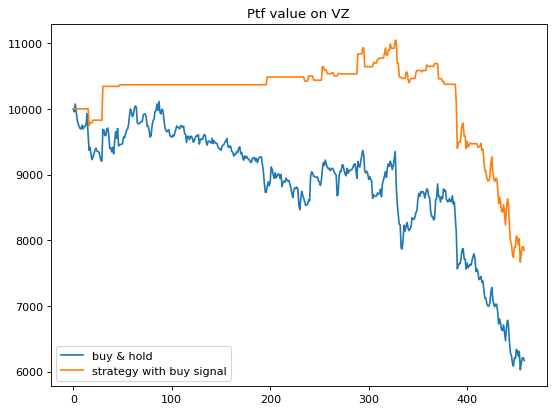

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


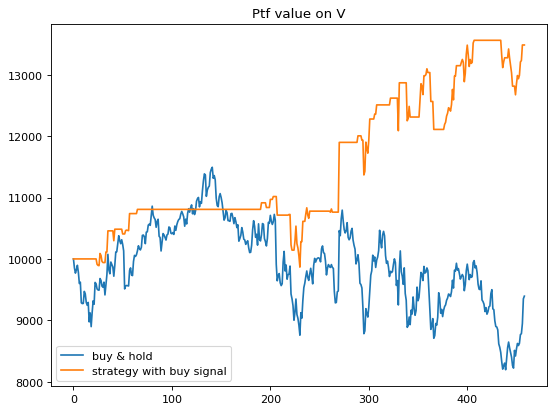

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


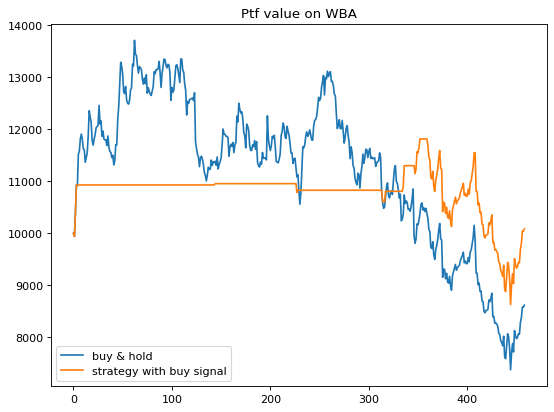

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


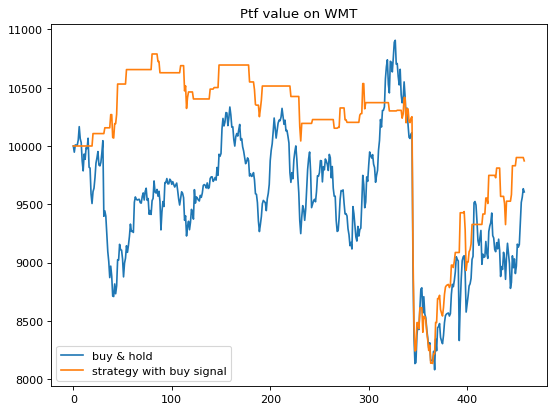

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


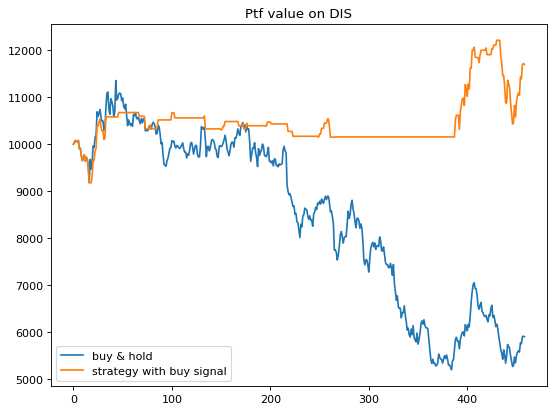

[*********************100%***********************]  1 of 1 completed


/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_880/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


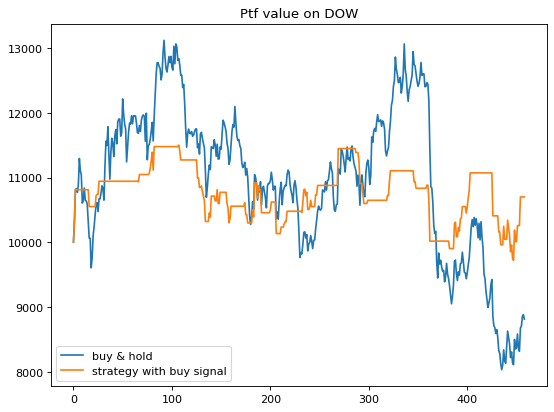

In [57]:
# Prepare Data for each ticker

returns = {}

for tic in dow_30_tickers:

    df = yf.download(tic, start = '2015-01-01')

    df = get_all_technical_indicators(df)

    df = add_next_day_return(df)

    date_start_train = '2015-01-01'
    date_end_train = '2021-01-01'  

    X_train, y_train, X_test, y_test = sep_train_test(df, date_start_train, date_end_train)

    X_scaled_train, y_scaled_train, X_scaled_test, y_scaled_test = sep_train_test_scaled(df, date_start_train, date_end_train)

    X_scaled_train.index = list(X_train.index)
    y_scaled_train.index = list(y_train.index)
    X_scaled_test.index = list(X_test.index)
    y_scaled_test.index = list(y_test.index)


    # Train model

    RF_reg = RandomForestRegressor(max_depth=10, random_state=0)
    RF_reg.fit(X_scaled_train, y_scaled_train)

    y_scaled_pred = RF_reg.predict(X_scaled_test)
    y_scaled_train_pred = RF_reg.predict(X_scaled_train)



    test = X_scaled_test
    test['y_pred'] = y_scaled_pred

    def buy_signal(row):
        if(row['y_pred'] < np.quantile(y_scaled_pred, 0.75)):
            val = 0
        else:
            val = 1
        return val

    test['buy_signal'] = test.apply(buy_signal, axis=1)

    X_test['buy_signal'] = test['buy_signal']



    # Implement strategy

    # We invest money_invested on our strategy

    trades = []
    money_invested = 10000

    money_available = money_invested
    current_portfolio_value = []

    num_shares_bought = [0 for i in range(len(X_test))]
    num_shares_sold = [0 for i in range(len(X_test))]


    i = 0
    is_bought = 0
    current_num_shares = 0

    while(i < (len(X_test))):
        if(is_bought):
            if(X_test.iloc[i]['buy_signal'] == 0):
                price_sell = X_test.iloc[i]['Close']
                #trades.append(price_sell - price_bought)
                is_bought = 0

                num_shares_sold[i] = current_num_shares
                money_available += current_num_shares * price_sell

                current_num_shares = 0

        else:
            if((X_test.iloc[i]['buy_signal'] == 1)):
                price_bought = X_test.iloc[i]['Close']
                is_bought = 1

                num_shares_bought[i] = money_available // X_test.iloc[i].Close
                current_num_shares = num_shares_bought[i]
                money_available -=  current_num_shares * price_bought
                #current_portfolio = current_portfolio - num_shares * X_test.iloc[0].Close

        current_portfolio_value.append(money_available + current_num_shares * X_test.iloc[i].Close)

        i += 1


    # Baseline : buy and hold strategy

    money_invested = 10000
    money_available_baseline = money_invested

    current_portfolio_baseline_value = []

    num_shares_baseline =  money_invested // X_test.iloc[0]['Close']
    money_available_baseline = money_invested % X_test.iloc[0]['Close']

    for i in range(len(X_test)):
        current_portfolio_baseline_value.append(money_available_baseline + num_shares_baseline * X_test.iloc[i].Close)

    # Plot results    

    figure(figsize=(8, 6), dpi=80)

    plt.plot(current_portfolio_baseline_value, label = 'buy & hold')
    plt.plot(current_portfolio_value, label = 'strategy with buy signal')
    plt.legend(loc="lower left")
    plt.title(f'Ptf value on {tic}')
    plt.show()
    
    returns[tic] = [round(100 * current_portfolio_value[-1] / money_invested, 1), round(100 * current_portfolio_baseline_value[-1] / money_invested, 1)]

In [70]:
results = pd.DataFrame(returns, index = ['momentum', 'buy & hold']).transpose()

In [71]:
results.describe()

,momentum,buy & hold
count,30.000000,30.000000
mean,112.003333,103.436667
std,19.316716,31.744014
min,75.600000,53.000000
25%,99.300000,86.675000
50%,110.850000,102.550000
75%,124.950000,117.475000
max,157.300000,210.000000
